# Build co-authorship networks of guideline researchers

In [ ]:
# Co-authorship networks of the guideline researchers

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.options.display.max_rows = 100
pd.options.display.max_colwidth = None
import pickle
from tqdm import tqdm
import seaborn as sns
import os, sys, gc, random, itertools, math, pickle
from itertools import combinations
import networkx as nx

In [8]:
authid_12 = np.load('/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/member_data/2021/A1.2_who_guideline_development_group.npy')
authid_13 = np.load('/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/member_data/A1.3_who_systematic_review_team_revise.npy')
authid_14 = np.load('/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/member_data/2021/A1.4_who_external_methodologists.npy')
authid_15 = np.load('//disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/member_data/A1.5_who_external_review_team_revise.npy')

boardmember_authid = list(authid_12)+list(authid_13)+list(authid_14)+list(authid_15)

In [4]:
authids_df = pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/authids.pickle')
authids_df = pd.DataFrame(authids_df)
authids_df.reset_index(inplace=True)
authids_df.rename(columns={'index':'eid'},inplace=True)

In [3]:
year_df = pd.read_pickle('/disks/qnap3/shared/scopus-24/data/paper/year.pickle')
year_df = pd.DataFrame(year_df)
year_df.reset_index(inplace=True)
year_df.rename(columns={'index':'eid'},inplace=True)

In [5]:
authids_explode_df = authids_df.explode('authids')

In [10]:
target_eid = authids_explode_df[authids_explode_df['authids'].isin(boardmember_authid)]['eid'].unique()

In [11]:
target_authids_df = authids_df[authids_df['eid'].isin(target_eid)]

In [12]:
target_authids_df = pd.merge(target_authids_df, year_df, on='eid', how='left')

In [13]:
def replace_values(authid_list):
    return [35780677200 if x == 7006806977 else 57206422848 if x == 54791745100  else 57219144066 if x == 55588756600  else 57219144066 if x == 57191727610  else 57219144066 if x == 14037485900 else x for x in authid_list]

target_authids_df['authids'] = target_authids_df['authids'].apply(replace_values)

In [14]:
target_authids_df.head()

,eid,authids,year
0,107793,"[7006131104, 7102294773, 7005693696, 55968390200, 56920788800]",2001
1,176024,"[35207209200, 35207209200, 7410184308, 7410184308, 35301101400, 7404700014, 7005491937, 57197605067, 25930906600, 7201888912, 6507838545]",1999
2,238404,"[35207209200, 35207209200, 7410184308, 7410184308, 35301101400, 7404700014, 7005491937, 57197605067, 25930906600, 7201888912, 6507838545]",1999
3,273101,"[6604043025, 23047979300, 7410000833, 7202704991, 7202943455, 23046215400, 6701380218, 57206155893, 7102623710]",1977
4,332071,"[15921073500, 7005586715, 7201804950, 6602731348, 6603940133]",1991


In [15]:
year = 2022
target_authids_df1 = target_authids_df[(target_authids_df['year']<=2021)]

In [16]:
G1 = nx.Graph()

for _, row in tqdm(target_authids_df1.iterrows(), total=len(target_authids_df1)):
    authids = row['authids']
    for auth1, auth2 in combinations(authids, 2):
        if auth1 != auth2:
            if G1.has_edge(auth1, auth2):
                G1[auth1][auth2]['weight'] += 1
            else:
                G1.add_edge(auth1, auth2, weight=1)
        else:
            continue

# Save with pickle
# with open("/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/co-author_network_2021/2021_coauthor_network_G_revise.pkl", "wb") as f:
#     pickle.dump(G1, f)

100%|███████████████████████████████████| 15361/15361 [01:02<00:00, 247.20it/s]


In [18]:
remove_nodes = []

for node in G1.nodes():
    if node not in boardmember_authid:
        remove_nodes.append(node)

In [19]:
G1.remove_nodes_from(remove_nodes)

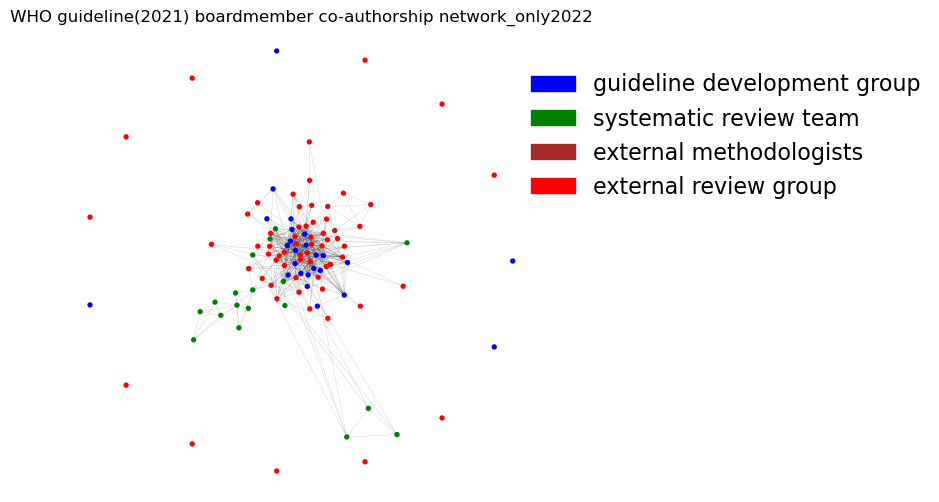

In [20]:
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import math

largest_cc = max(nx.connected_components(G1), key=len)
subgraph = G1.subgraph(largest_cc)

pos = nx.kamada_kawai_layout(subgraph)

# isolated_nodes = [n for n in G.nodes() if nx.is_isolate(G, n)]
isolated_nodes = [n for n in G1.nodes() if n not in subgraph.nodes()]


num_isolated = len(isolated_nodes)
radius = 1.2
for i, node in enumerate(isolated_nodes):
    angle = 2 * math.pi * i / num_isolated
    x = radius * math.cos(angle)
    y = radius * math.sin(angle)
    pos[node] = (x, y)

fig, ax = plt.subplots(figsize=(6, 6))


node_colors = []
for c in G1.nodes():
    if c in authid_12:
        node_colors.append('blue')
    elif c in authid_13:
        node_colors.append('green')
    elif c in authid_14:
        node_colors.append('brown')
    elif c in authid_15:
        node_colors.append('red')
    else:
        print(c)
        node_colors.append('gray')


# color_map = {
#     'blue':'guideline development group',
#     'green':'systematic review team',
#     'brown':'external methodologists',
#     'red':'external review group -individual experts'
# }
      
nx.draw(
    G1, pos, node_color=node_colors, node_size=8, width=0.055,ax=ax
)
plt.title(f"WHO guideline(2021) boardmember co-authorship network_only{year}")

legend_patches = [mpatches.Patch(color='blue', label='guideline development group'),
                  mpatches.Patch(color='green', label='systematic review team'),
                  mpatches.Patch(color='brown', label='external methodologists'),
                  mpatches.Patch(color='red', label='external review group')
                  ]
# plt.title('"airborne particulate"', x=0.5, y=-0.0025, fontsize=16)
plt.legend(handles=legend_patches,  bbox_to_anchor=(0.95,0.95), fontsize=16, frameon=False)

plt.show()

In [86]:
# # Save with pickle
# with open(f"/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/co-author_network_2021/revise_0111/only_co_author_network_G_before2021.pkl", "wb") as f:
#     pickle.dump(G1, f)

In [ ]:
# Co-authorship networks of co-authors of the guideline researchers

In [21]:
coauthor_authids = authids_explode_df[authids_explode_df['eid'].isin(target_eid)]['authids'].unique()

In [23]:
co_coauthor_eid = authids_explode_df[authids_explode_df['authids'].isin(coauthor_authids)]['eid'].unique()

In [24]:
df_auth_cocoauthors = authids_df[authids_df['eid'].isin(co_coauthor_eid)]

In [25]:
df_auth_cocoauthors.shape

(3441313, 2)

In [26]:
def replace_values(authid_list):
    return [35780677200 if x == 7006806977 else 57206422848 if x == 54791745100  else 57219144066 if x == 55588756600  else 57219144066 if x == 57191727610  else 57219144066 if x == 14037485900 else x for x in authid_list]

df_auth_cocoauthors['authids'] = df_auth_cocoauthors['authids'].apply(replace_values)

/tmp/ipykernel_483243/3574602117.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_auth_cocoauthors['authids'] = df_auth_cocoauthors['authids'].apply(replace_values)


In [ ]:
G2 = nx.Graph()

for _, row in tqdm(df_auth_cocoauthors.iterrows(), total=len(df_auth_cocoauthors)):
    authids = row['authids']
    for auth1, auth2 in combinations(authids, 2):
        if auth1 != auth2:
            if G2.has_edge(auth1, auth2):
                G2[auth1][auth2]['weight'] += 1
            else:
                G2.add_edge(auth1, auth2, weight=1)
        else:
            continue

# Save with pickle
# with open("/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/co-author_network_2021/revise_0111/co_coauthorship/2021_co_coauthor_network_G_revise_correct_authids.pkl", "wb") as f:
#    pickle.dump(G2, f)

In [ ]:
#with open("/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/co-author_network_2021/revise_0111/co_coauthorship/2021_co_coauthor_network_G_revise_correct_authids_resave.pkl", "wb") as f:
#    pickle.dump(G2, f)

In [39]:
with open('/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/co-author_network_2021/revise_0111/co_coauthorship/2021_co_coauthor_network_G_revise_correct_authids_resave.pkl', 'rb') as f:
    G2 = pickle.load(f)


In [27]:
cited_eid = np.load('/disks/qnap3/users/21-tomokiyo/masters_thesis/data/guideline_paper/ref_data/2021/who_guideline_ref_eids.npy')

In [28]:
cited_authids = authids_df[authids_df['eid'].isin(cited_eid)]

In [29]:
cited_authids.head()

,eid,authids
12615369,27362097,"[7004937075, 7004937075, 57193089483, 57193089483, 57193089483, 34868966600, 7102395742, 57202555597, 7102585610, 56974691900, 57208455828, 57208455828]"
13858467,28802284,"[7103362401, 57225397374, 57202615405, 7004665680, 7101950462, 7404060133, 10739972800, 7102627126, 6507180436, 57204337226, 35832825900, 7401650526]"
17504810,33006078,"[7005616584, 7102763785, 7005035331, 57110165500, 7003874846, 35380028700, 20236659700]"
18162362,33791138,"[7005035331, 18936140900, 56560727000, 10042846400, 7005616584]"
20979105,37029043,"[57193089483, 26643599300, 26643599300, 7006846858, 7005657669, 24565152100, 13606042300, 7102270013]"


In [30]:
def replace_values(authid_list):
    return [35780677200 if x == 7006806977 else 57206422848 if x == 54791745100  else 57219144066 if x == 55588756600  else 57219144066 if x == 57191727610  else 57219144066 if x == 14037485900 else x for x in authid_list]

cited_authids['authids'] = cited_authids['authids'].apply(replace_values)

/tmp/ipykernel_483243/3445953074.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cited_authids['authids'] = cited_authids['authids'].apply(replace_values)


In [32]:
cited_authids.head()

,eid,authids
12615369,27362097,"[7004937075, 7004937075, 57193089483, 57193089483, 57193089483, 34868966600, 7102395742, 57202555597, 7102585610, 56974691900, 57208455828, 57208455828]"
13858467,28802284,"[7103362401, 57225397374, 57202615405, 7004665680, 7101950462, 7404060133, 10739972800, 7102627126, 6507180436, 57204337226, 35832825900, 7401650526]"
17504810,33006078,"[7005616584, 7102763785, 7005035331, 57110165500, 7003874846, 35380028700, 20236659700]"
18162362,33791138,"[7005035331, 18936140900, 56560727000, 10042846400, 7005616584]"
20979105,37029043,"[57193089483, 26643599300, 26643599300, 7006846858, 7005657669, 24565152100, 13606042300, 7102270013]"


In [33]:
cited_authids['author_len'] = cited_authids['authids'].apply(lambda x: len(x))

/tmp/ipykernel_483243/3576215859.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cited_authids['author_len'] = cited_authids['authids'].apply(lambda x: len(x))


In [34]:
cited_paper_authids = cited_authids.explode('authids')['authids'].unique()

In [35]:
len(cited_paper_authids)

2554

In [40]:
min_distance_dict = {}

for index, row in tqdm(cited_authids.iterrows(), total=len(cited_authids)):
    target_authids = row['authids']
    distance_ls = []
    valid_target_authids = [authid for authid in target_authids if authid in G2.nodes()]

    shortest_distance = np.inf
    for authid in valid_target_authids:
        for guideline_authid in boardmember_authid:
            if guideline_authid in G2.nodes():
                try:
                    shortest_distance = nx.shortest_path_length(G2, source=authid, target=guideline_authid)
                    distance_ls.append(shortest_distance)
                    if shortest_distance == 0:
                        break
                except nx.NetworkXNoPath:
                    pass
        if shortest_distance == 0:
            break

    if distance_ls:
        min_distance = min(distance_ls)
    else:
        min_distance = None
    min_distance_dict[row['eid']] = min_distance


100%|████████████████████████████████████████| 183/183 [02:23<00:00,  1.28it/s]


In [41]:
distance_array = np.array(list(min_distance_dict.values()))
distance_array

array([0, 1, 1, 1, 0, 1, 2, 0, None, 0, 1, 2, 1, 2, 1, 2, 0, 0, 0, 2, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 2, 2, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1,
       1, 2, 0, 0, 1, None, 0, 0, 0, 2, 0, 2, 0, 1, 0, 1, 0, 1, 1, 2, 0,
       0, 0, 0, 0, 0, 2, 1, 0, 1, 1, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, None, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 2, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0,
       1, 0, 0, 0, 0, 1, 0, 0, 0, 0], dtype=object)

In [42]:
distance_array = distance_array.astype(str)

In [43]:
# The output values are used for the table1
np.unique(distance_array, return_counts=True)

(array(['0', '1', '2', 'None'], dtype='<U4'), array([101,  65,  14,   3]))